In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OrdinalEncoder
from glob import glob
from IPython.display import display
from ipywidgets import interact, fixed
from mlxtend.plotting import plot_decision_regions
from scipy.stats import percentileofscore
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels
from tqdm import tnrange, tqdm_notebook


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 200)

In [3]:
# files = glob('LoanStats*.csv')

# def a_to_d_done(df):
#     a_to_d = df['grade'].isin(['A', 'B', 'C', 'D'])
#     done = df['loan_status'].isin(['Fully Paid', 'Charged Off'])
#     return a_to_d & done

# dfs = (pd.read_csv(file, skiprows=1, skipfooter=2, engine='python')
#        .where(a_to_d_done)
#        .dropna(subset=['grade', 'loan_status'])
#        for file in tqdm_notebook(files))

# df = pd.concat(dfs)

In [4]:
# historical, _ = train_test_split(df.copy(), train_size=0.10, 
#                              stratify=df['loan_status'])

In [5]:
# historical.to_csv('historical.csv', index=False)

In [6]:
df = pd.read_csv('data/historical.csv')
df.shape

(128334, 144)

In [7]:
current = pd.read_csv('data/primaryMarketNotes_browseNotes_1-RETAIL.csv')
current.shape

(58, 122)

In [8]:
common = set(df.columns) & set(current.columns)
hist = set(df.columns) - set(current.columns)
curr = set(current.columns) - set(df.columns)

In [9]:
common

{'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'loan_amnt',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num

In [10]:
hist

{'collection_recovery_fee',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'funded_amnt_inv',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'loan_status',
 'next_pymnt_d',
 'orig_projected_additional_accrued_interest',
 'out_prncp',
 'out_prncp_inv',
 'payment_plan_start_date',
 'policy_code',
 'pymnt_plan',
 'recoveries',
 'settlement_amount',
 'settlement_date',
 'settlement_percentage',
 'settlement_status',
 'settlement_term',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'verification_status',
 'verification_status_joint'}

In [11]:
curr

{'accept_d',
 'credit_pull_d',
 'disbursement_method',
 'effective_int_rate',
 'exp_d',
 'exp_default_rate',
 'fico_range_high',
 'fico_range_low',
 'housing_payment',
 'ils_exp_d',
 'is_inc_v',
 'list_d',
 'msa',
 'mtg_payment',
 'review_status',
 'review_status_d',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'service_fee_rate',
 'verified_status_joint'}

In [12]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24000.0,24000.0,24000.0,36 months,11.48%,791.20,B,B5,captain,10+ years,MORTGAGE,85000.0,Verified,Jan-2016,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,853xx,AZ,33.60,0.0,Sep-1994,1.0,NaN,65.0,12.0,1.0,27828.0,85%,53.0,w,0.0,0.0,24555.220000,24555.22,24000.0,555.22,0.0,0.0,0.0,Mar-2016,23779.33,NaN,Aug-2017,0.0,74.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,371447.0,1.0,2.0,0.0,2.0,13.0,91449.0,83.0,2.0,5.0,7367.0,85.0,32850.0,2.0,7.0,3.0,8.0,30953.0,4179.0,94.0,0.0,0.0,168.0,256.0,5.0,5.0,4.0,7.0,NaN,3.0,NaN,0.0,7.0,9.0,12.0,13.0,29.0,9.0,19.0,9.0,12.0,NaN,0.0,0.0,3.0,98.0,85.7,0.0,0.0,397767.0,119277.0,29250.0,109901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,12000.0,12000.0,12000.0,36 months,14.33%,412.06,C,C2,"Demorizi & Polanco, M.D., P.A.",3 years,RENT,75000.0,Not Verified,Sep-2013,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,331xx,FL,9.06,0.0,Nov-1999,1.0,34.0,NaN,12.0,0.0,8060.0,57.2%,20.0,w,0.0,0.0,14289.000000,14289.00,12000.0,2289.00,0.0,0.0,0.0,Oct-2015,3623.68,NaN,Nov-2015,0.0,34.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,10107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14100.0,NaN,NaN,NaN,5.0,1123.0,1982.0,75.5,0.0,0.0,31.0,168.0,4.0,4.0,0.0,16.0,34.0,4.0,34.0,0.0,3.0,6.0,3.0,9.0,1.0,11.0,19.0,6.0,12.0,0.0,0.0,0.0,1.0,75.0,33.3,0.0,0.0,26380.0,10107.0,8100.0,12280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,25450.0,25450.0,25450.0,60 months,11.55%,560.36,B,B3,U.S. Army,10+ years,MORTGAGE,57000.0,Verified,Jul-2013,Fully Paid,n,NaN,Borrower added on 06/27/13 > I

In [13]:
current.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,accept_d,exp_d,list_d,credit_pull_d,review_status_d,review_status,url,desc,purpose,title,zip_code,addr_state,msa,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,mths_since_recent_inq,mths_since_recent_revol_delinq,mths_since_recent_bc,mort_acc,open_acc,pub_rec,total_bal_ex_mort,revol_bal,revol_util,total_bc_limit,total_acc,total_il_high_credit_limit,num_rev_accts,mths_since_recent_bc_dlq,initial_list_status,ils_exp_d,pub_rec_bankruptcies,num_accts_ever_120_pd,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,mths_since_last_major_derog,num_sats,num_tl_op_past_12m,mo_sin_rcnt_tl,tot_hi_cred_lim,tot_cur_bal,avg_cur_bal,num_bc_tl,num_actv_bc_tl,num_bc_sats,pct_tl_nvr_dlq,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_il_tl,mo_sin_old_il_acct,num_actv_rev_tl,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,effective_int_rate,application_type,disbursement_method,annual_inc_joint,dti_joint,verified_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mtg_payment,housing_payment,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,152167636,186565679,22000.0,19675.0,60,11.71,5.49,0.73,486.16,B,B3,NaN,< 1 year,MORTGAGE,60000.0,Not Verified,05-24-2019 06:08:38,07-07-2019 14:00:00,06-07-2019 14:00:00,05-21-2019 09:55:17,06-07-2019 10:00:50,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Credit card refinancing,Credit card refinancing,751xx,TX,NaN,0,2,13573,40.0,58.2,14.65,0,0.0,12-20-1999 16:00:00,665,669,1,52,,3,,2,5,9,0,21005,21005.0,54.6,32500,26,0,15,,f,NaN,0,0,0,0,0,NaN,9,2,2,103750,75437,8382,8,4,5,96,0,0,0,6,154,5,226,2,38500,5,8,989,11.60,INDIVIDUAL,DIRECT_PAY,,,,2,0,0,0,73,0.0,,2,2,9285.0,54.6,0,3,2,736.00,,,,,,,,,,,,,,
1,153003150,188095322,28000.0,26725.0,36,8.19,2.16,0.86,879.88,A,A4,NaN,< 1 year,RENT,80000.0,Not Verified,06-06-2019 21:39:53,07-07-2019 18:00:00,06-07-2019 18:00:00,06-04-2019 20:38:53,06-07-2019 13:56:56,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidation,Debt consolidation,921xx,CA,NaN,0,1,13197,75.0,71.0,32.19,0,0.0,09-04-2005 17:00:00,715,719,0,,,16,,40,0,14,0,135969,32303.0,71.0,45500,33,140166,12,,f,NaN,0,0,0,0,0,NaN,14,0,16,185666,135969,9712,12,7,8,100,0,0,0,21,156,7,165,40,45500,7,8,0,8.18,INDIVIDUAL,CASH,,,,0,6,0,1,16,103666.0,58.7,0,0,7843.0,63.0,1,2,0,0.00,,,,,,,,,,,,,,
2,152654206,187356227,27000.0,22500.0,36,10.33,5.15,1.01,875.41,B,B1,Logistics Manager,1 year,RENT,72000.0,Source Verified,06-05-2019 07:21:02,07-06-2019 10:00:00,06-06-2019 10:00:00,05-30-2019 04:47:10,06-06-2019 06:02:41,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Credit card refinancing,Credit card refinancing,480xx,MI,NaN,0,4,5880,40.0,75.0,21.38,0,0.0,02-27-2007 16:00:00,675,679,0,25,74,8,,22,0,10,1,35499,22028.0,54.9,23500,19,24193,10,,f,NaN,1,1,0,1,0,25.0,10,2,4,64293,35499,3550,5,3,5,94,0,0,0,9,110,4,147,4,40100,4,8,151,10.22,INDIVIDUAL,DIRECT_PAY,,,,1,2,1,2,7,13471.0,55.7,1,2,11381.0,55.2,1,1,2,0.00,,,,,,,,,,,,,,
3,152209289,186627083,40000.0,15725.0,36,25.00,12.86,1.42,1590.40,D,D4,NaN,3 years,MORTGAGE,9500.0,Verified,05-27-2019 08:52:04,07-08-2019 14:00:00,06-08-2019 14:00:00,05-21-2019 15:03:03,06-08-2019 09:57:43,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidatio

In [14]:
dic = pd.read_excel('data/LCDataDictionary.xlsx')
dic.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


Find baseline of expected value of random note choice.

In [15]:
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)
df['percent_paid'] = df['total_pymnt'] / df['funded_amnt']
df.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.545939,0.279100,0.0,0.327767,0.513106,0.745365,1.585171
Fully Paid,105857.0,1.146813,0.089585,1.0,1.083836,1.131872,1.195880,1.600152


In [16]:
def monte_carlo(n=10000,
                investment=1000,
                grades=['A', 'B', 'C', 'D'],
                start='2007-07-01',
                end='2019-03-01'):
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start) &
                 (df['issue_d'] <= end))
    
    notes = df[condition]
    
    sims = []
    
    for _ in tnrange(n):
        mine = notes.sample(investment // 25).copy()
        mine['paid'] = 25 * mine['percent_paid']
        gross = mine['paid'].sum()
        sims.append(gross)
        
    sims = pd.Series(sims)
    sns.distplot(sims)
    plt.axvline(x=investment)
    percent = percentileofscore(sims, investment)
    plt.title(f'{percent}% of sims did not profit.\nDates: {start} - {end}\nLoan Grades: {grades}')

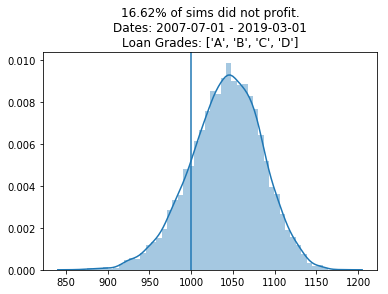

In [17]:
monte_carlo()

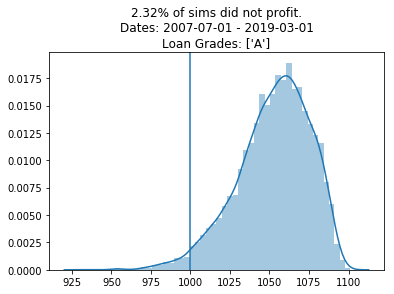

In [18]:
monte_carlo(grades=['A'])

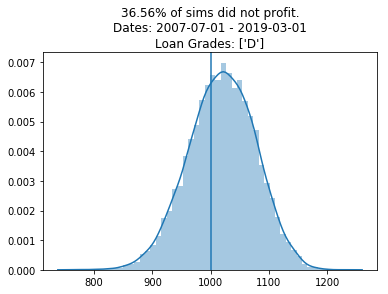

In [19]:
monte_carlo(grades=['D'])

Remove features to avoid leakage.

In [20]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], infer_datetime_format=True)
df['earliest_cr_line'] = df['issue_d'] - df['earliest_cr_line']
df['earliest_cr_line'] = df['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

In [21]:
features = list(common)
target = 'loan_status'
X = df[features]
y = df[target]

In [22]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          test_size=20000,
                                                          stratify=y,
                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  test_size=20000,
                                                  stratify=y_trainval,
                                                  random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (88334, 102)
X_val shape: (20000, 102)
X_test shape: (20000, 102)
y_train shape: (88334,)
y_val shape: (20000,)
y_test shape: (20000,)


Get accuracy score for majority class.

In [23]:
y_train.value_counts(normalize=True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [24]:
majority = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority)
accuracy_score(y_val, y_pred)

0.82485

In [25]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

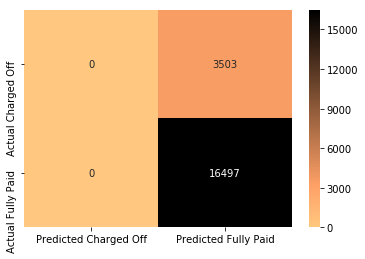

In [26]:
nice_confusion(y_val, y_pred);

In [27]:
print(classification_report(y_val, y_pred))

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      3503
  Fully Paid       0.82      1.00      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.75     20000



Predict 100% probability for majority class.

In [28]:
y_pred_proba = np.full_like(y_val, fill_value=1.0)
roc_auc_score(y_val, y_pred_proba)

0.5

In [29]:
y_pred_proba

array([1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0], dtype=object)

Any constant will result in a 0.5 roc_auc

There are lots of missing values

In [30]:
nulls = X_train.isnull().sum().sort_values(ascending=False)
nulls = nulls.index[:73].tolist()

['id',
 'url',
 'member_id',
 'sec_app_mths_since_last_major_derog',
 'sec_app_revol_util',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_open_acc',
 'sec_app_num_rev_accts',
 'sec_app_open_act_il',
 'revol_bal_joint',
 'sec_app_mort_acc',
 'annual_inc_joint',
 'dti_joint',
 'desc',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'il_util',
 'mths_since_rcnt_il',
 'all_util',
 'total_bal_il',
 'open_il_12m',
 'open_rv_12m',
 'open_rv_24m',
 'open_il_24m',
 'max_bal_bc',
 'inq_last_12m',
 'open_acc_6m',
 'total_cu_tl',
 'open_act_il',
 'inq_fi',
 'mths_since_last_delinq',
 'mths_since_recent_inq',
 'num_tl_120dpd_2m',
 'mo_sin_old_il_acct',
 'emp_title',
 'emp_length',
 'pct_tl_nvr_dlq',
 'num_op_rev_tl',
 'num_actv_bc_tl',
 'num_rev_accts',
 'num_actv_rev_tl',
 'tot_coll_amt',
 'num_il_tl',
 'num_rev_tl_bal_gt_0',
 '

In [31]:
def clean_it_up(data, high_nulls):
    df = data.copy()
    
    # Percentage strings -> float.
    df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['revol_util'] = df['revol_util'].str.strip('%').astype(float)
    
    # Make some employee categories.
    df['emp_title'] = df['emp_title'].str.lower()
    df['emp_teacher'] = df['emp_title'].str.contains('teacher', na=False)
    df['emp_nurse'] = df['emp_title'].str.contains('nurse|rn', na=False)
    df['emp_mid_manage'] = df['emp_title'].str.contains('manager|supervisor', na=False)
    df['emp_up_manage'] = df['emp_title'].str.contains('owner|director|president|officer|^c.o$')
    
    # Columns with many NANs converted to binary.
    for col in high_nulls:
        df[col] = df[col].isnull()
    
    # Drop columns.
    df = df.drop(columns=['id',
                          'member_id',
                          'title',
                          'grade',
                          'zip_code'
                         ])
    
    # Impute mean for features with fewer NANs
    for col in df:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())
    
    # Transform sub_grade to float ranking 1.1 -7.5
    def sub_grade(x):
        first = ord(x[0]) - 64
        last = int(x[1]) / 10
        return first + last
    
    df['sub_grade'] = df['sub_grade'].apply(sub_grade)

    return df


In [32]:
X_train = clean_it_up(X_train, nulls)
X_val = clean_it_up(X_val, nulls)
X_test = clean_it_up(X_test, nulls)

In [33]:
X_train.shape, X_val.shape, X_test.shape

((88334, 101), (20000, 101), (20000, 101))

Train a model.

In [34]:
pipeline = make_pipeline(
                         OrdinalEncoder(),
                         RandomForestClassifier(n_estimators=100,
                                                n_jobs=-1, 
                                                random_state=42)
                        )

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['home_ownership', 'purpose', 'term',
                                      'application_type', 'addr_state',
                                      'initial_list_status', 'emp_up_manage'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'home_ownership',
                                          'data_type': dtype('O'),
                                          'mapping': MORTGAGE    1
RENT        2
OWN         3
ANY         4
OTHER       5
NONE        6
NaN        -2
dtype: i...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                 

In [35]:
# Accuracy score.
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.8244

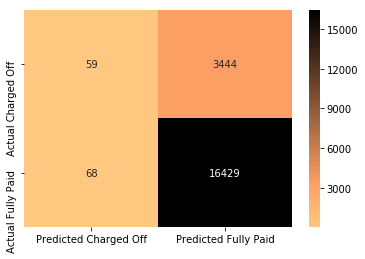

In [36]:
# Confusion matrix.
nice_confusion(y_val, y_pred);

In [37]:
# Precision and recall.
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.46      0.02      0.03      3503
  Fully Paid       0.83      1.00      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.65      0.51      0.47     20000
weighted avg       0.76      0.82      0.75     20000



In [38]:
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.6845209323692812

Visulalize ROC curve.

In [39]:
def set_threshold(y_true, y_pred_proba, threshold):
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate}')
    print(f'False Positive Rate: {false_pos_rate}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba)}')
    
    nice_confusion(y_true, y_pred)
    print(classification_report(y_true, y_pred))


In [40]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Use the class_weight parameter in sklearn.

In [41]:
def train_val_test_split(X, 
                         y,
                         train_size=.8,
                         val_size=.1,
                         test_size=.1,
                         random_state=42,
                         shuffle=True):
    
    assert train_size + val_size + test_size == 1
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=test_size,
                                                              random_state=random_state,
                                                              shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                      y_trainval,
                                                      test_size=val_size / (train_size + val_size),
                                                      random_state=random_state,
                                                      shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [54]:
def class_weighter(n_samples=1000, weights=(0.95, 0.5), class_sep=.8, class_weight=None):
    X, y = make_classification(n_samples=n_samples,
                               n_features=2,
                               n_informative=2,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2, 
                               n_clusters_per_class=1,
                               weights=weights,
                               class_sep=class_sep,
                               random_state=42)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,
                                                                          y,
                                                                          train_size=.8,
                                                                          val_size=.1,
                                                                          test_size=.1,
                                                                          random_state=42)
    
    
    model = LogisticRegression(solver='lbfgs',
                               class_weight=class_weight)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    nice_confusion(y_val, y_pred)
    
    plt.figure(figsize=(10, 6))
    plot_decision_regions(X_val, y_val, model, legend=0);

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        94
           1       0.38      0.50      0.43         6

    accuracy                           0.92       100
   macro avg       0.67      0.72      0.69       100
weighted avg       0.93      0.92      0.93       100



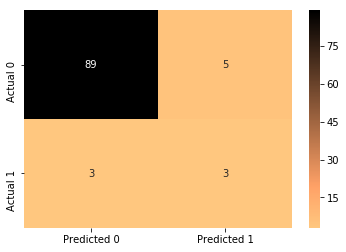

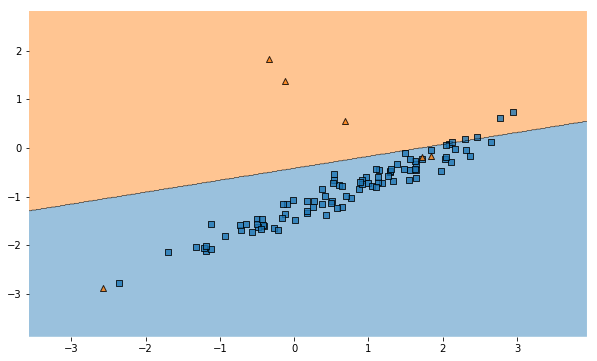

In [75]:
class_weighter()

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        94
           1       0.38      0.50      0.43         6

    accuracy                           0.92       100
   macro avg       0.67      0.72      0.69       100
weighted avg       0.93      0.92      0.93       100



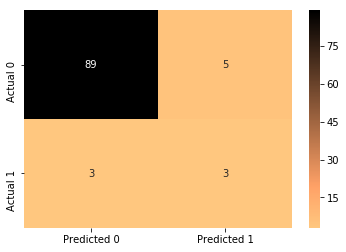

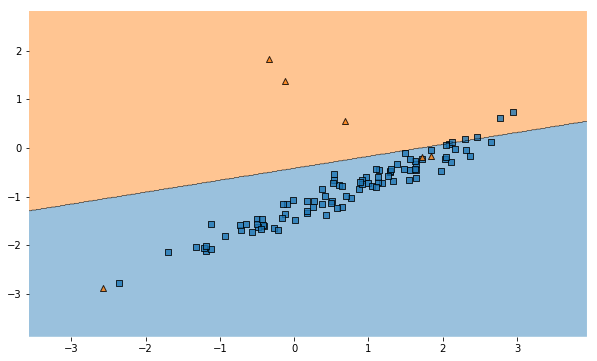

In [60]:
class_weighter(class_weight='balanced')

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        94
           1       0.60      0.50      0.55         6

    accuracy                           0.95       100
   macro avg       0.78      0.74      0.76       100
weighted avg       0.95      0.95      0.95       100



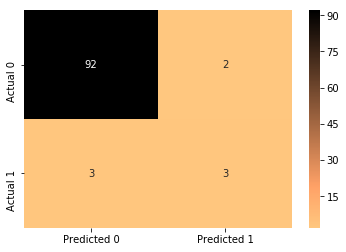

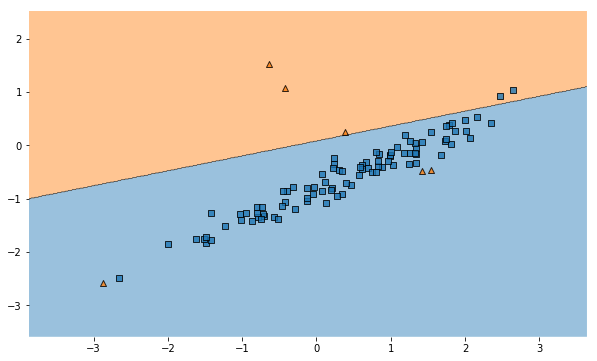

In [74]:
class_weighter(class_sep=.5, class_weight={0:1, 1:10})